<a href="https://colab.research.google.com/github/ajeyamk/causalvae/blob/master/vae_ajeya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl
!pip3 install torch torchvision
!pip3 install pydrive --upgrade

Requirement already up-to-date: pydrive in /usr/local/lib/python3.6/dist-packages (1.3.1)


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os

import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
from pyro.contrib.examples.util import print_and_log
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

# from custom_mlp import MLP, Expxt

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Hack to get all available GPU ram.
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.6 GB  | Proc size: 3.5 GB
GPU RAM Free: 14310MB | Used: 769MB | Util   5% | Total 15079MB


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# https://drive.google.com/open?id=1mAtimHIWHJM2UJNxsIylPyI1jUebGIx-
custom_mlp_module = drive.CreateFile({'id':'1mAtimHIWHJM2UJNxsIylPyI1jUebGIx-'})

In [0]:
custom_mlp = custom_mlp_module.GetContentFile('custom_mlp.py')
from custom_mlp import MLP, Exp

In [0]:
class SVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks) and models & guides needed to train a
    semi-supervised variational auto-encoder on the Dsprites image dataset

    :param output_size: size of the tensor representing the class label 
    :param input_size: size of the tensor representing the image (64*64 = 4096 for our Dsprites dataset
                       since we flatten the images and scale the pixels to be in [0,1])
    :param z_dim: size of the tensor representing the latent random variable z
                  (for our Dsprites dataset)
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """
    def __init__(self, output_size=6, input_size=4096, z_dim=50, hidden_layers=(500,),
                 config_enum=None, use_cuda=USE_CUDA, aux_loss_multiplier=None):

        super(SVAE, self).__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):

        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers

        # define the neural networks used later in the model and the guide.
        # these networks are MLPs (multi-layered perceptrons or simple feed-forward networks)
        # where the provided activation parameter is used on every linear layer except
        # for the output layer where we use the provided output_activation parameter
        self.encoder_y = MLP([self.input_size] + hidden_sizes + [self.output_size],
                             activation=nn.Softplus,
                             output_activation=nn.Softmax,
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
        self.encoder_z = MLP([self.input_size + self.output_size] +
                             hidden_sizes + [[z_dim, z_dim]],
                             activation=nn.Softplus,
                             output_activation=[None, Exp],
                             allow_broadcast=self.allow_broadcast,
                             use_cuda=self.use_cuda)

        self.decoder = MLP([z_dim + self.output_size] +
                           hidden_sizes + [self.input_size],
                           activation=nn.Softplus,
                           output_activation=nn.Sigmoid,
                           allow_broadcast=self.allow_broadcast,
                           use_cuda=self.use_cuda)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # dsprites label (latent)
        p(y|x) = categorical(I/10.)     # which digit (supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = torch.ones(batch_size, self.output_size, **options) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)

            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = categorical(alpha(x))              # infer label from an image
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer latent class from an image and the label
        loc, scale are given by a neural network `encoder_z`
        alpha is given by a neural network `encoder_y`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: (optional) a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # if the class label (the digit) is not supervised, sample
            # (and score) the digit with the variational distribution
            # q(y|x) = categorical(alpha(x))
            if ys is None: 
                alpha = self.encoder_y.forward(xs)
                ys = pyro.sample("y", dist.OneHotCategorical(alpha))

            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z.forward([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, xs):
        """
        classify an image (or a batch of images)

        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        # use the trained model q(y|x) = categorical(alpha(x))
        # compute all class probabilities for the image(s)
        alpha = self.encoder_y.forward(xs)

        # get the index (digit) that corresponds to
        # the maximum predicted class probability
        res, ind = torch.topk(alpha, 1)

        # convert the digit(s) to one-hot tensor(s)
        ys = torch.zeros_like(alpha).scatter_(1, ind, 1.0)
        return ys

    def model_classify(self, xs, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".  It 
        probably isn't needed here.
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                alpha = self.encoder_y.forward(xs)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.OneHotCategorical(alpha), obs=ys)

    def guide_classify(self, xs, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass

In [0]:
def setup_data_loaders(train_x, train_y, test_x, test_y, batch_size=128, use_cuda=USE_CUDA):
    train_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(train_y.astype(np.float32))
    )
    test_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(test_y.astype(np.float32))
    )    
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    loader = {}
    loader["sup"] = torch.utils.data.DataLoader(
        dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    loader["valid"] = test_loader
    loader["test"] = test_loader
    return loader

def run_supervized_inference_for_epoch(data_loaders, losses):
    """
    runs the inference algorithm for an epoch
    returns the values of all losses separately on supervised and unsupervised parts
    """
    num_losses = len(losses)

    # compute number of batches for an epoch
    batches_per_epoch = len(data_loaders["sup"])

    # initialize variables to store loss values
    epoch_losses = [0.] * num_losses

    # setup the iterators for training data loaders
    sup_iter = iter(data_loaders["sup"])

    for i in range(batches_per_epoch):

        # extract the corresponding batch
        (xs, ys) = next(sup_iter)
        xs = xs.cuda()
        ys = ys.cuda()
        # run the inference for each loss with supervised or un-supervised
        # data as arguments
        for loss_id in range(num_losses):
            new_loss = losses[loss_id].step(xs, ys)
            epoch_losses[loss_id] += new_loss

    # return the values of all losses
    return epoch_losses


In [0]:
dataset_zip = np.load(
    '/content/gdrive/My Drive/data-science/causal-ml/projects/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
      return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

# Sample latents randomly
latents_sampled = sample_latent(size=70000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:], latents_sampled[1000:],
    imgs_sampled[:1000], latents_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)

In [0]:
def get_accuracy(data_loader, classifier_fn, batch_size):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    
    for (xs, ys) in data_loader:
        xs = xs.cuda()
        ys = ys.cuda()
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(xs))
        actuals.append(ys)

    # compute the number of accurate predictions
    accurate_preds = 0
    for pred, act in zip(predictions, actuals):
        for i in range(pred.size(0)):
            v = torch.sum(pred[i] == act[i])
            accurate_preds += (v.item() == 10)

    # calculate the accuracy between 0 and 1
    accuracy = (accurate_preds * 1.0) / (len(predictions) * batch_size)
    return accuracy


def visualize(s_vae, viz, test_loader):
    if viz:
        plot_conditional_samples_ssvae(s_vae, viz)
        mnist_test_tsne_ssvae(ssvae=s_vae, test_loader=test_loader)

In [0]:
sup_vae = SVAE(
    output_size=6,
    input_size=4096,
    z_dim=50,
    hidden_layers=[500],
    use_cuda=USE_CUDA,
    config_enum="parallel",
    aux_loss_multiplier=46
)

In [0]:
adam_params = {"lr": 0.00042, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)
# set up the loss(es) for inference. wrapping the guide in config_enumerate builds
# the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution
# in the model
guide = config_enumerate(sup_vae.guide, "parallel", expand=True)
elbo = Trace_ELBO(max_plate_nesting=1)
loss_basic = SVI(sup_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]
loss_aux = SVI(sup_vae.model_classify, sup_vae.guide_classify, optimizer, loss=elbo)
losses.append(loss_aux)

In [17]:
sup_vae

SVAE(
  (encoder_y): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): DataParallel(
        (module): Linear(in_features=4096, out_features=500, bias=True)
      )
      (2): Softplus(beta=1, threshold=20)
      (3): Linear(in_features=500, out_features=6, bias=True)
      (4): Softmax()
    )
  )
  (encoder_z): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): DataParallel(
        (module): Linear(in_features=4102, out_features=500, bias=True)
      )
      (2): Softplus(beta=1, threshold=20)
      (3): ListOutModule(
        (0): Sequential(
          (0): Linear(in_features=500, out_features=50, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=500, out_features=50, bias=True)
          (1): Exp()
        )
      )
    )
  )
  (decoder): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): DataParallel(
        (module): Linear(in_features=56, out_features=500, bias=True)
     

In [36]:
sup_num = 60000
batch_size = 256
num_epochs = 100

logger = open("./tmp.log", "w")
# Number of supervised number

# initializing local variables to maintain the best validation accuracy
# seen across epochs over the supervised training set
# and the corresponding testing set and the state of the networks
best_valid_acc, corresponding_test_acc = 0.0, 0.0

# run inference for a certain number of epochs
for i in range(0, num_epochs):

    # get the losses for an epoch
    epoch_losses_sup = run_supervized_inference_for_epoch(
        data_loaders,
        losses
    )

    # compute average epoch losses i.e. losses per example
    avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)

    # store the loss and validation/testing accuracies in the logfile
    str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))

    str_print = "{} epoch: avg loss {}".format(i, "{}".format(str_loss_sup))

    validation_accuracy = get_accuracy(data_loaders["valid"], sup_vae.classifier, batch_size)
    str_print += " validation accuracy {}".format(validation_accuracy)

    # this test accuracy is only for logging, this is not used
    # to make any decisions during training
    test_accuracy = get_accuracy(data_loaders["test"], sup_vae.classifier, batch_size)
    str_print += " test accuracy {}".format(test_accuracy)

    # update the best validation accuracy and the corresponding
    # testing accuracy and the state of the parent module (including the networks)
    if best_valid_acc < validation_accuracy:
        best_valid_acc = validation_accuracy
        corresponding_test_acc = test_accuracy
        
    visualize(sup_vae, None, data_loaders["test"])

    print_and_log(logger, str_print)

final_test_accuracy = get_accuracy(data_loaders["test"], sup_vae.classifier, batch_size)
print_and_log(logger, "best validation accuracy {} corresponding testing accuracy {} "
              "last testing accuracy {}".format(best_valid_acc, corresponding_test_acc, final_test_accuracy))

# close the logger file object if we opened it earlier
logger.close()

0 epoch: avg loss 73.4194898127238 10.337283599853516 validation accuracy 0.0 test accuracy 0.0
1 epoch: avg loss 73.1135249282837 9.959152315266927 validation accuracy 0.0 test accuracy 0.0
2 epoch: avg loss 72.90056605784098 9.599737705485026 validation accuracy 0.0 test accuracy 0.0
3 epoch: avg loss 72.72961992340088 9.309077065022786 validation accuracy 0.0 test accuracy 0.0
4 epoch: avg loss 72.53395691884359 8.995561258951822 validation accuracy 0.0 test accuracy 0.0
5 epoch: avg loss 72.29241495920817 8.699117222086588 validation accuracy 0.0 test accuracy 0.0
6 epoch: avg loss 72.0966392674764 8.405718975830078 validation accuracy 0.0 test accuracy 0.0
7 epoch: avg loss 71.84623018544515 8.126094775390625 validation accuracy 0.0 test accuracy 0.0
8 epoch: avg loss 71.72414229482015 7.864214937337239 validation accuracy 0.0 test accuracy 0.0
9 epoch: avg loss 71.49476098785401 7.599710852050781 validation accuracy 0.0 test accuracy 0.0
10 epoch: avg loss 71.34665864410401 7.383

In [0]:
def reconstruct_image_w_label(xs, ys, vae):
    # backward
    xs = xs.cuda()
    ys = ys.cuda()
    sim_z_loc, sim_z_scale = vae.encoder_z([xs, ys])
    zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
    # forward
    zs = zs.cuda()
    ys = ys.cuda()
    loc = vae.decoder([zs, ys])
    return dist.Bernoulli(loc).to_event(1).sample()

def reconstruct_image(xs, vae):
    # backward
    xs = xs.cuda()
    sim_ys = vae.encoder_y(xs)
    sim_z_loc, sim_z_scale = vae.encoder_z([xs, sim_ys])
    zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
    # forward
    zs = zs.cuda()
    loc = vae.decoder([zs, ys.cuda()])
    return dist.Bernoulli(loc).to_event(1).sample()

def convert_back(x):
    return x.cpu().reshape(-1, 64, 64).numpy().astype(np.uint8)

def show_images_grid(imgs_, num_images):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
          ax.imshow(imgs_[ax_i].reshape(64, 64), cmap='Greys_r',  interpolation='nearest')
          ax.set_xticks([])
          ax.set_yticks([])
        else:
          ax.axis('off')

def viz_images(imgs, n):
    imgs_ = []
    for i, x in enumerate(imgs):
        if i > n:
            break
        imgs_.append(convert_back(x))
    show_images_grid(np.array(imgs_), n)

Four original images 

In [0]:
sup_iter = iter(data_loaders["sup"])
xs, ys = next(sup_iter)

With y and x:


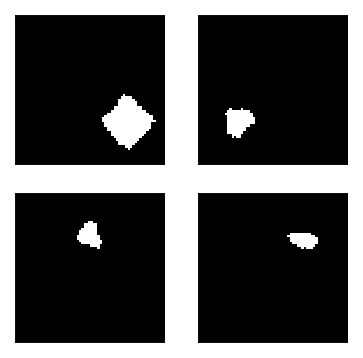

In [38]:
print("With y and x:")
xs_sim1 = reconstruct_image_w_label(xs, ys, sup_vae)
viz_images(xs_sim1, 4)

With just x:


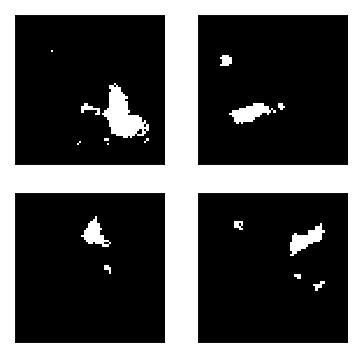

In [39]:
print("With just x:")
# backward
xs_sim2 = reconstruct_image(xs, sup_vae)
viz_images(xs_sim2, 4)

In [0]:
xs_sim2.shape

torch.Size([256, 4096])